In [1]:
import matplotlib 
from matplotlib import cm
#permette di aprire le immagini in cartelle a parte, separate dal notebook
#matplotlib.use('Qt5Agg')

#import astropy
from scipy import odr
from pylab import *
from scipy.optimize import curve_fit
import sep
from astropy.io import fits
import matplotlib.pyplot as plt 
import numpy as np
from astropy.stats import sigma_clipped_stats
from astropy.modeling import models, fitting
from astropy import table
from astropy.table import QTable
import astropy.units as u
from astropy.io import ascii

from matplotlib.patches import Ellipse

import os

from scipy.stats import chisquare

# ABBIAMO RIORDINATO LE CARTELLE, OCCHIO AI PERCORSI

In [2]:
fit_riferimento = ascii.read('file:///data1/astlab04/SPS/6_filtri/DUST/Fit_RIFERIMENTOPlots/Fit_values.txt')
fit_ROSSO_CENTRALE = ascii.read('file:///data1/astlab04/SPS/6_filtri/DUST/ROSSO_CENTRALEPlots/Fit_values.txt')
fit_MEGAROSSO_CENTRALE = ascii.read('file:///data1/astlab04/SPS/6_filtri/DUST/MEGAROSSO_CENTRALEPlots/Fit_values.txt')
fit_LATI = ascii.read('file:///data1/astlab04/SPS/6_filtri/DUST/LATIPlots/Fit_values.txt')

In [3]:
#mettere in ordine per lunghezza d'onda crescente
fit_vec = [fit_riferimento, fit_ROSSO_CENTRALE, fit_LATI, fit_MEGAROSSO_CENTRALE]
sorg_vect = ['s10101','s12945','s13989','s15166','s15839','s2033','s2225', 's2236', 's23442', 's23669']
par_vect = ['TAU_50','AGE_50', 'AV_50', 'ALPHA_50', 'LMASS_50',  'AGE_GAS_50', 'ION_GAS_50', 'LSFR_50']

In [4]:
fit_riferimento

ID,TAU_16,TAU_50,TAU_84,AGE_16,AGE_50,AGE_84,AV_16,AV_50,AV_84,ALPHA_16,ALPHA_50,ALPHA_84,LMASS_16,LMASS_50,LMASS_84,AGE_GAS_16,AGE_GAS_50,AGE_GAS_84,ION_GAS_16,ION_GAS_50,ION_GAS_84,LSFR_16,LSFR_50,LSFR_84,LNZ,CHI2_PHOT
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10101,882.634,2570.071,11705.784,891.873,1085.112,2073.782,0.35,0.439,0.509,0.336,0.808,1.419,9.421,9.454,9.532,0.68,1.048,1.622,-3.322,-2.966,-2.497,0.228,0.228,0.32,237.227,31.059
12945,2259.912,2531.292,2819.32,6344.817,6686.886,6866.014,2.032,2.051,2.068,0.412,0.953,1.665,10.807,10.822,10.836,2.598,6.157,8.657,-3.503,-2.573,-1.524,0.305,0.305,0.374,230.191,11.121
13989,2688.528,3074.966,3574.858,5204.644,5730.486,6342.492,0.585,0.599,0.616,0.906,2.298,3.397,10.718,10.74,10.76,4.724,8.959,9.798,-3.934,-3.433,-2.322,0.521,0.521,0.535,15.366,78.58
15166,5958.319,11883.363,17304.366,426.038,486.249,566.325,0.976,1.003,1.026,2.513,3.108,3.708,9.594,9.621,9.645,6.584,8.339,9.537,-3.75,-3.122,-1.985,0.915,0.915,0.958,237.655,5.449
15839,5361.178,11152.669,16653.7,656.848,835.978,1060.835,0.292,0.34,0.393,0.78,1.969,3.312,9.095,9.14,9.182,0.805,1.488,4.273,-3.396,-2.862,-2.054,0.199,0.199,0.258,255.161,1.373
2033,310.155,335.285,402.767,5447.735,5544.988,5697.728,0.118,0.124,0.129,1.478,2.704,3.589,11.276,11.281,11.286,3.321,7.175,9.203,-3.67,-2.786,-1.609,-4.647,-4.647,-3.392,-707.776,318.795
2225,4359.509,8734.233,13891.463,107.414,123.668,145.576,1.754,1.786,1.821,0.604,1.37,2.788,9.396,9.416,9.441,7.206,8.147,9.174,-3.777,-3.466,-2.986,1.321,1.321,1.36,225.211,6.722
2236,7088.41,12585.99,17342.695,789.535,943.423,1114.394,0.205,0.237,0.271,0.788,2.108,3.303,9.466,9.5,9.526,4.562,7.546,9.165,-3.617,-2.736,-1.579,0.502,0.502,0.543,250.941,0.608
23442,5266.622,11507.435,17106.804,227.76,278.346,332.06,1.052,1.087,1.117,2.773,3.331,3.767,9.562,9.605,9.641,4.531,7.551,9.22,-3.664,-2.745,-1.602,1.162,1.162,1.198,240.816,3.739


In [5]:
#creo "matrice" a 3 entrate: la prima fissa la sorgente, dopodichè per ogni sorgente ho una tabella 
#con 8 parametri e 10 filtri (9 + quella di riferimento)


m_s = np.zeros([10,8,4])
for s in range (0,10): #sorgenti
    for i in range (0,4): #filtri: 0 = RIFERIMENTO, 1 = SOLO ROSSI, 2 = SOLO BLU (vd cavolo sotto)
        m_s[s,0,i] = fit_vec[i]['TAU_50'][s]
        m_s[s,1,i] = fit_vec[i]['AGE_50'][s]
        m_s[s,2,i] = fit_vec[i]['AV_50'][s]
        m_s[s,3,i] = fit_vec[i]['ALPHA_50'][s]
        m_s[s,4,i] = fit_vec[i]['LMASS_50'][s]
        m_s[s,5,i] = fit_vec[i]['AGE_GAS_50'][s]
        m_s[s,6,i] = fit_vec[i]['ION_GAS_50'][s]
        m_s[s,7,i] = fit_vec[i]['LSFR_50'][s]

In [6]:
########D'ORA IN AVANTI: SOLO ROSSI = no filtri blu (U,IA484). SOLO BLU = no filtri rossi (F160W, K, IRAC1, IRAC2)

cavolo = ['RIFERIMENTO','CENTRALE','LATI', 'MEGACENTRALE'] 
err_abs = ['ERR_ABS_RIF', 'ERR_ABS_CENTRALE', 'ERR_ABS_LATI', 'ERR_ABS_MEGACENTRALE']
err_rel = ['ERR_REL_RIF', 'ERR_REL_CENTRALE', 'ERR_REL_LATI', 'ERR_REL_MEGACENTRALE']
z = [0.7281, 0.7393, 0.735, 0.7272, 0.7385, 0.728, 0.7281, 0.7287, 0.7307, 0.7499]


##creiamo una tabella per ogni parametro in cui abbiamo nelle righe le sorgenti con i valori dei parametri senza i
#vari filtri, una colonna con gli errori assoluti, una con gli errori relativi e una con 
#il rapporto degli errori relativi. Questo rapporto mi dà l'influenza del filtro nel ricavare quel parametro: se >1 
#domina il blu

for i in range (0,8):
    
    t = QTable(m_s[:,i,:], names = cavolo)  #trasforma matrice in tabella con header chiamata cavolo.
                                            #é una variabile interna al ciclo: non salviamo ogni tabella in un                                        
                                            #vettore, viene sovrascritta ad ogni iterazione
                                            
    
    if i == 4: #SELEZIONO PARAMETRO DELLA MASSA: log10 of the stellar mass (Msun)
        for u in range (0,4):
            t.add_column(table.Column( (fit_vec[u]['LMASS_84']-fit_vec[u]['LMASS_16'])/2 ), name = err_abs[u])
            t.add_column(table.Column( (fit_vec[u]['LMASS_84']-fit_vec[u]['LMASS_16']) / (2*fit_vec[u]['LMASS_50']) ), name = err_rel[u])
        t.add_column( table.Column( ( (fit_vec[1]['LMASS_84']-fit_vec[1]['LMASS_16']) / (2*fit_vec[1]['LMASS_50']) )/( (fit_vec[2]['LMASS_84']-fit_vec[2]['LMASS_16'])/(2*fit_vec[2]['LMASS_50']) ) ), name = 'err_R/err_B')         
        t.add_column( table.Column( ( (fit_vec[3]['LMASS_84']-fit_vec[3]['LMASS_16']) / (2*fit_vec[3]['LMASS_50']) )/( (fit_vec[2]['LMASS_84']-fit_vec[2]['LMASS_16'])/(2*fit_vec[2]['LMASS_50']) ) ), name = 'err_MR/err_B')         

    
    if i == 2: #SELEZIONO PARAMETRO DELLA DUST: dust attenuation in V-band (mag)
        for u in range (0,4):
            t.add_column(table.Column( (fit_vec[u]['AV_84']-fit_vec[u]['AV_16'])/2 ), name = err_abs[u])
            t.add_column(table.Column( np.abs(  (fit_vec[u]['AV_84']-fit_vec[u]['AV_16']) / (2*fit_vec[u]['AV_50'])  ) ), name = err_rel[u])
        t.add_column( table.Column( np.abs(  ( (fit_vec[1]['AV_84']-fit_vec[1]['AV_16']) / (2*fit_vec[1]['AV_50']) )/( (fit_vec[2]['AV_84']-fit_vec[2]['AV_16'])/(2*fit_vec[2]['AV_50']) )  ) ), name = 'err_R/err_B')
        t.add_column( table.Column( np.abs(  ( (fit_vec[3]['AV_84']-fit_vec[3]['AV_16']) / (2*fit_vec[3]['AV_50']) )/( (fit_vec[2]['AV_84']-fit_vec[2]['AV_16'])/(2*fit_vec[2]['AV_50']) )  ) ), name = 'err_MR/err_B')

    
    if i == 7: #SELEZIONO PARAMETRO DELLA SFR: log10 of the star formation rate (Msun/yr)
        for u in range (0,4):
            t.add_column( table.Column( (fit_vec[u]['LSFR_84']-fit_vec[u]['LSFR_16'])/2 ), name = err_abs[u] )
            t.add_column( table.Column( np.abs(  (fit_vec[u]['LSFR_84']-fit_vec[u]['LSFR_16']) / (2*fit_vec[u]['LSFR_50'])  ) ), name = err_rel[u] ) 
        t.add_column( table.Column( np.abs(  ( (fit_vec[1]['LSFR_84']-fit_vec[1]['LSFR_16']) / (2*fit_vec[1]['LSFR_50']) )/( (fit_vec[2]['LSFR_84']-fit_vec[2]['LSFR_16'])/(2*fit_vec[2]['LSFR_50']) )  ) ), name = 'err_R/err_B') 
        t.add_column( table.Column( np.abs(  ( (fit_vec[3]['LSFR_84']-fit_vec[3]['LSFR_16']) / (2*fit_vec[3]['LSFR_50']) )/( (fit_vec[2]['LSFR_84']-fit_vec[2]['LSFR_16'])/(2*fit_vec[2]['LSFR_50']) )  ) ), name = 'err_MR/err_B') 
    
    
    t.add_column(table.Column(sorg_vect), name = 'Sorgente')
    t.add_column(table.Column(z), name = 'z')
    
    t1 = fits.BinTableHDU(t) #converto la tebella in BinTable
    
    #t1.writeto(par_vect[i]+'DUST.fits') #salvo nella cartella di lavoro come file fits

In [10]:
t

RIFERIMENTO,CENTRALE,LATI,MEGACENTRALE,ERR_ABS_RIF,ERR_REL_RIF,ERR_ABS_CENTRALE,ERR_REL_CENTRALE,ERR_ABS_LATI,ERR_REL_LATI,ERR_ABS_MEGACENTRALE,ERR_REL_MEGACENTRALE,err_R/err_B,err_MR/err_B,Sorgente,z
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64
0.228,-0.002,0.485,0.018,0.046,0.20175438596491227,0.116,58.0,0.04749999999999999,0.09793814432989688,0.0835,4.638888888888889,592.2105263157896,47.36549707602341,s10101,0.7281
0.305,0.929,0.599,1.577,0.0345,0.11311475409836066,0.08950000000000002,0.0963401506996771,0.019500000000000017,0.03255425709515863,0.01200000000000001,0.007609384908053273,2.9593718086721297,0.23374469538071313,s12945,0.7393
0.521,0.965,0.663,1.602,0.007000000000000006,0.013435700575815751,0.08249999999999996,0.08549222797927457,0.013499999999999956,0.02036199095022618,0.012499999999999956,0.007802746566791483,4.198618307426609,0.3832015536135385,s13989,0.735
0.915,0.398,0.892,0.696,0.021499999999999964,0.0234972677595628,0.10649999999999998,0.2675879396984924,0.02250000000000002,0.025224215246636792,0.11700000000000005,0.16810344827586216,10.608375209380224,6.664367816091952,s15166,0.7272
0.199,-0.181,0.288,-0.076,0.0295,0.14824120603015073,0.1085,0.5994475138121547,0.048500000000000015,0.16840277777777785,0.08499999999999999,1.118421052631579,3.5596058552144427,6.6413456321215385,s15839,0.7385
-4.647,1.379,-2.721,-0.404,0.6275000000000002,0.1350333548525931,0.10399999999999998,0.07541696881798403,0.40900000000000003,0.15031238515251746,0.064,0.15841584158415842,0.5017348952414047,1.05391077005011,s2033,0.728
1.321,0.567,0.723,0.913,0.019500000000000073,0.014761544284632909,0.07850000000000001,0.13844797178130516,0.11249999999999999,0.15560165975103735,0.04399999999999993,0.04819277108433727,0.8897589653145211,0.3097188755020075,s2225,0.7281
0.502,0.161,0.535,0.257,0.020500000000000018,0.040836653386454216,0.0765,0.47515527950310554,0.019999999999999962,0.037383177570093386,0.046999999999999986,0.18287937743190655,12.710403726708098,4.892023346303509,s2236,0.7287
1.162,0.394,0.845,0.369,0.018000000000000016,0.015490533562822734,0.0655,0.16624365482233502,0.04350000000000004,0.05147928994082845,0.17099999999999999,0.46341463414634143,3.229330766089034,9.001962433417429,s23442,0.7307


In [11]:
m_s[:,4,:] #lmass

array([[ 9.454,  9.713,  9.304,  9.736],
       [10.822, 10.683, 10.718, 10.186],
       [10.74 , 10.721, 10.721, 10.303],
       [ 9.621, 10.13 ,  9.641,  9.816],
       [ 9.14 ,  9.459,  9.061,  9.315],
       [11.281, 11.158, 11.225, 11.244],
       [ 9.416, 10.292,  9.852,  9.783],
       [ 9.5  ,  9.757,  9.44 ,  9.645],
       [ 9.605, 10.126,  9.837,  9.996],
       [ 9.808,  9.961,  9.466, 10.043]])

In [12]:
m_s[:,7,:] #lsfr

array([[ 2.280e-01, -2.000e-03,  4.850e-01,  1.800e-02],
       [ 3.050e-01,  9.290e-01,  5.990e-01,  1.577e+00],
       [ 5.210e-01,  9.650e-01,  6.630e-01,  1.602e+00],
       [ 9.150e-01,  3.980e-01,  8.920e-01,  6.960e-01],
       [ 1.990e-01, -1.810e-01,  2.880e-01, -7.600e-02],
       [-4.647e+00,  1.379e+00, -2.721e+00, -4.040e-01],
       [ 1.321e+00,  5.670e-01,  7.230e-01,  9.130e-01],
       [ 5.020e-01,  1.610e-01,  5.350e-01,  2.570e-01],
       [ 1.162e+00,  3.940e-01,  8.450e-01,  3.690e-01],
       [ 8.700e-02,  2.970e-01,  9.180e-01,  1.820e-01]])

In [13]:
m_s[:,2,:] #dust

array([[0.439, 0.281, 0.647, 0.233],
       [2.051, 2.666, 1.743, 2.694],
       [0.599, 1.319, 0.737, 1.619],
       [1.003, 1.111, 0.98 , 1.122],
       [0.34 , 0.233, 0.407, 0.173],
       [0.124, 1.465, 0.173, 0.449],
       [1.786, 2.48 , 1.265, 1.873],
       [0.237, 0.184, 0.246, 0.07 ],
       [1.087, 0.722, 0.843, 0.387],
       [0.237, 0.267, 0.842, 0.16 ]])

In [14]:
tab_dust = fits.open('file:///data1/astlab04/AV_50DUST.fits')

In [15]:
tab_dust[1].data

FITS_rec([(0.439, 0.281, 0.647, 0.233, 0.0795, 0.18109339, 0.2055, 0.73131673, 0.079 , 0.12210201, 0.1475, 0.63304721,  5.98939141,  5.18457652, 's10101', 0.7281),
          (2.051, 2.666, 1.743, 2.694, 0.018 , 0.00877621, 0.1635, 0.06132783, 0.0525, 0.03012048, 0.0245, 0.00909428,  2.03608402,  0.30193022, 's12945', 0.7393),
          (0.599, 1.319, 0.737, 1.619, 0.0155, 0.02587646, 0.1265, 0.09590599, 0.02  , 0.02713704, 0.0105, 0.00648548,  3.53413571,  0.23899012, 's13989', 0.735 ),
          (1.003, 1.111, 0.98 , 1.122, 0.025 , 0.02492522, 0.1995, 0.17956796, 0.0615, 0.0627551 , 0.2375, 0.21167558,  2.86140809,  3.37304175, 's15166', 0.7272),
          (0.34 , 0.233, 0.407, 0.173, 0.0505, 0.14852941, 0.1955, 0.83905579, 0.0625, 0.15356265, 0.134 , 0.77456647,  5.46393133,  5.04397688, 's15839', 0.7385),
          (0.124, 1.465, 0.173, 0.449, 0.0055, 0.04435484, 0.1165, 0.07952218, 0.02  , 0.11560694, 0.018 , 0.04008909,  0.68786689,  0.3467706 , 's2033', 0.728 ),
          (1.786,

In [16]:
#plottiamo riferimenti vs i vari filtri
###Fittiamo i dati con una retta

def lineare(p,x):
    m, q = p
    y = m*x + q
    return y


quad_model1 = odr.Model(lineare)
data1 = odr.RealData(tab_dust[1].data['RIFERIMENTO'], tab_dust[1].data['CENTRALE'] , sx = tab_dust[1].data['ERR_ABS_RIF'], sy = tab_dust[1].data['ERR_ABS_CENTRALE']) #rif vs centrale
odr1 = odr.ODR(data1, quad_model1, beta0 = [1.,0.])
out1 = odr1.run()
print ('1 =', out1.beta)

quad_model2 = odr.Model(lineare)
data2 = odr.RealData(tab_dust[1].data['RIFERIMENTO'], tab_dust[1].data['LATI'] , sx = tab_dust[1].data['ERR_ABS_RIF'], sy = tab_dust[1].data['ERR_ABS_LATI']) #rif vs LATI
odr2 = odr.ODR(data2, quad_model2, beta0 = [1.,0.])
out2 = odr2.run()
print ('2 =', out2.beta)


quad_model3 = odr.Model(lineare)
data3 = odr.RealData(tab_dust[1].data['RIFERIMENTO'], tab_dust[1].data['MEGACENTRALE'] , sx = tab_dust[1].data['ERR_ABS_RIF'], sy = tab_dust[1].data['ERR_ABS_MEGACENTRALE']) #rif vs MEGAcentrale
odr3 = odr.ODR(data3, quad_model3, beta0 = [1.,0.])
out3 = odr3.run()
print ('3 =', out3.beta)






1 = [0.92049188 0.51595401]
2 = [0.80650072 0.19260617]
3 = [1.29204585 0.38826198]


In [17]:
#### calcoliamo chi quadro e p-value per ogni fit (cioè calcolarli tra il fit e la bisettrice)

#rif vs centro
a = np.linspace(0.01, 2.3, 10)
centro = (a*out1.beta[0] + out1.beta[1])
chi_centro, p_centro = chisquare(centro, f_exp = a)
print ('RIF VS CENTRO:\n', 'chi_2 = ',chi_centro ,'\n p_value = ', p_centro)



#rif vs lati
lati = (a*out2.beta[0] + out2.beta[1])
chi_lati, p_lati = chisquare(lati, f_exp = a)
print ('\nRIF VS LATI:\n', 'chi_2 = ',chi_lati ,'\n p_value = ', p_lati)


#rif vs megacentro
megacentro = (a*out3.beta[0] + out3.beta[1])
chi_megacentro, p_megacentro = chisquare(megacentro, f_exp = a)
print ('\nRIF VS MEGACENTRO:\n', 'chi_2 = ',chi_megacentro ,'\n p_value = ', p_megacentro)

RIF VS CENTRO:
 chi_2 =  28.771735764303244 
 p_value =  0.0007080482508026846

RIF VS LATI:
 chi_2 =  3.8006765426305025 
 p_value =  0.9240347999232197

RIF VS MEGACENTRO:
 chi_2 =  19.96889809829036 
 p_value =  0.01810531866985543


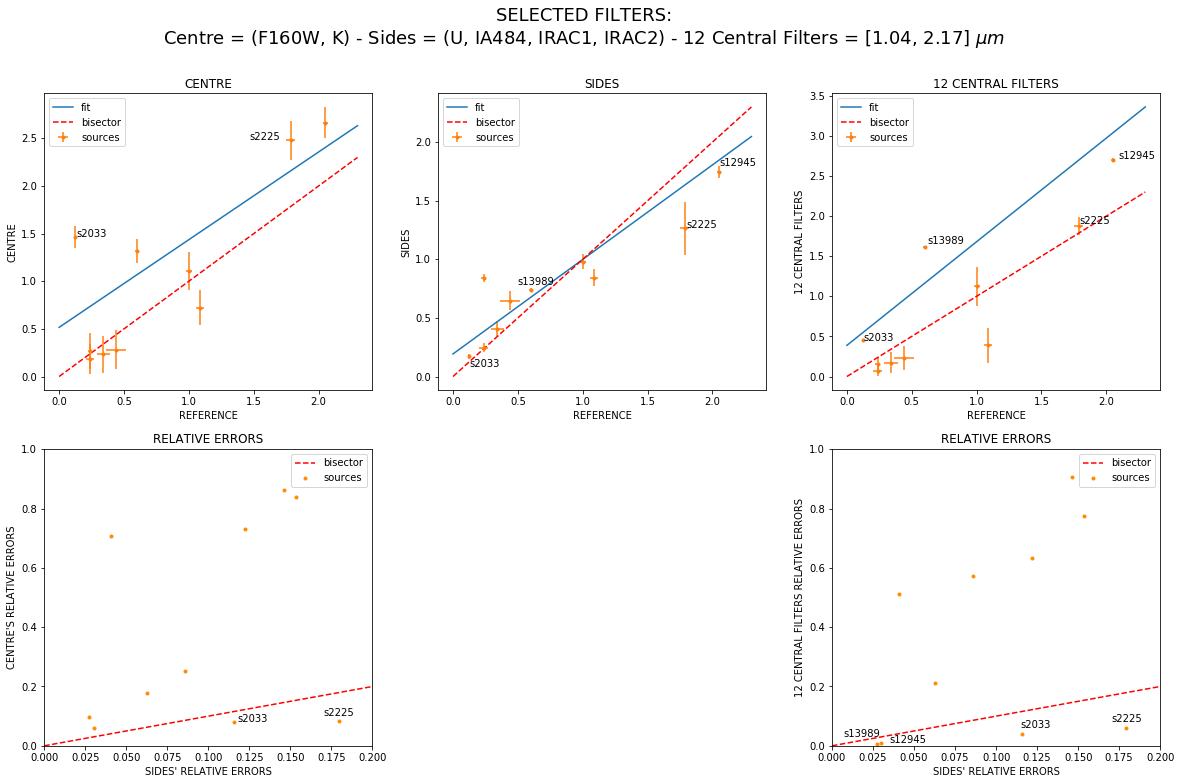

In [31]:
fig = plt.figure( figsize = (20, 12))

plt.suptitle('SELECTED FILTERS:\n'+
             r'Centre = (F160W, K) - Sides = (U, IA484, IRAC1, IRAC2) - 12 Central Filters = [1.04, 2.17] $\mu m$',
             fontsize = 18 )

plt.subplot(2,3,1)
plt.title('CENTRE')

x = np.linspace(0,2.3,10000)
plt.plot(x, x*out1.beta[0] + out1.beta[1], label = 'fit')
#label_fit = r'$\chi^2$ = '+ str(round(chi_centro, 1)) + r', p$_{value}$ = '+ str(round(p_centro, 3))
plt.plot(x,x, 'r', ls ='--', label = 'bisector')

plt.errorbar(tab_dust[1].data['RIFERIMENTO'],
             tab_dust[1].data['CENTRALE'], 
             xerr= tab_dust[1].data['ERR_ABS_RIF'],
             yerr= tab_dust[1].data['ERR_ABS_CENTRALE'], 
             fmt='.', label = 'sources')



plt.xlabel('REFERENCE')
plt.ylabel('CENTRE')
plt.legend(loc = 'best')
plt.annotate(xy = (1.47,2.48), s = 's2225')
plt.annotate(xy = (0.134,1.465), s = 's2033')

plt.subplot(2,3,2)
plt.title('SIDES')

x = np.linspace(0,2.3,10000)
plt.plot(x, x*out2.beta[0] + out2.beta[1], label = 'fit')
#label_fit2 = r'$\chi^2$ = '+ str(round(chi_lati, 1)) + r', p$_{value}$ = '+ str(round(p_lati, 3))
plt.plot(x,x, 'r', ls ='--', label = 'bisector')

plt.errorbar(tab_dust[1].data['RIFERIMENTO'],
             tab_dust[1].data['LATI'],
             xerr= tab_dust[1].data['ERR_ABS_RIF'], 
             yerr= tab_dust[1].data['ERR_ABS_LATI'], fmt='.', label = 'sources')

plt.xlabel('REFERENCE')
plt.ylabel('SIDES')
plt.legend(loc = 'best')
plt.annotate(xy = (1.796,1.265), s = 's2225')
plt.annotate(xy = (0.124,0.08), s = 's2033')
plt.annotate(xy = (2.05,1.8), s = 's12945')
plt.annotate(xy = (0.5,0.78), s = 's13989')

plt.subplot(2,3,3)
plt.title('12 CENTRAL FILTERS')

x = np.linspace(0,2.3,10000)
plt.plot(x, x*out3.beta[0] + out3.beta[1], label = 'fit')
#label_fit3 = r'$\chi^2$ = '+ str(round(chi_megacentro, 1)) + r', p$_{value}$ = '+ str(round(p_megacentro, 3))
#plt.plot(x,x, c = 'None', ls ='--', label = label_fit3)
plt.plot(x,x, 'r', ls ='--', label = 'bisector')
plt.errorbar(tab_dust[1].data['RIFERIMENTO'],
             tab_dust[1].data['MEGACENTRALE'],
             xerr= tab_dust[1].data['ERR_ABS_RIF'],
             yerr= tab_dust[1].data['ERR_ABS_MEGACENTRALE'], 
             fmt='.', label = 'sources')

plt.xlabel('REFERENCE')
plt.ylabel('12 CENTRAL FILTERS')
plt.annotate(xy = (0.126,0.45), s = 's2033')
plt.annotate(xy = (1.789,1.90), s = 's2225')
plt.annotate(xy = (2.09, 2.71), s = 's12945')
plt.annotate(xy = (0.62, 1.65), s = 's13989')
plt.legend(loc = 'best')


plt.subplot(2,3,4)
plt.title('RELATIVE ERRORS')

x5 = np.linspace(0,6.1,1000)
#RETTE
#plt.plot(x,x*out2.beta[0] + out2.beta[1], label = 'fit')
plt.plot(x5, x5, 'r', ls ='--', label = 'bisector')
#DATI
plt.errorbar(tab_dust[1].data['ERR_REL_LATI'],
             tab_dust[1].data['ERR_REL_CENTRALE'],
             c='darkorange', fmt='.', label = 'sources')
#STILE plt
plt.annotate(xy = (0.17,0.1), s = 's2225')
plt.annotate(xy = (0.118,0.079), s = 's2033')
plt.xlabel(r"SIDES' RELATIVE ERRORS")
plt.ylabel(r"CENTRE'S RELATIVE ERRORS")
plt.xlim(0,0.2)
plt.ylim(0,1)
#plt.xscale('Log')
#plt.yscale('Log')
plt.legend(loc = 'best')

plt.subplot(2,3,6)
plt.title('RELATIVE ERRORS')

x5 = np.linspace(0,6.1,1000)
#RETTE
#plt.plot(x,x*out2.beta[0] + out2.beta[1], label = 'fit')
plt.plot(x5, x5, 'r', ls ='--', label = 'bisector')
#DATI
plt.errorbar(tab_dust[1].data['ERR_REL_LATI'],
             tab_dust[1].data['ERR_REL_MEGACENTRALE'],
             c='darkorange', fmt='.', label = 'sources')
#STILE plt

plt.xlabel(r"SIDES' RELATIVE ERRORS")
plt.ylabel(r'12 CENTRAL FILTERS RELATIVE ERRORS')
plt.xlim(0,0.2)
plt.ylim(0,1)
plt.annotate(xy = (0.115, 0.06), s = 's2033')
plt.annotate(xy = (0.17, 0.08), s ='s2225')
plt.annotate(xy = (0.035,0.009), s = 's12945')
plt.annotate(xy = (0.007, 0.03), s ='s13989')
plt.legend(loc = 'best')

plt.savefig('dust.png')

potrebbe andare come ci aspettiamo: rif vs lati non si allontana troppo dal riferimento (filtri blu e molto rossi sono importanti per vedere uno spettro credibile), rif vs centro peggiora tanto e rif vs megacentro va leggermente meglio ma sono entrambi molto lontano dai lati.

Abbiamo fatto questa cosa con il "megacentro" (fit con tanti filtri nella zona centrale) perchè volevamo capire se era la carenza di filtri a danneggiare il fit che fa il codice oppure se era dovuto alla sensibilità del filtro verso l'emissione della polvere. 

dobbiamo chiedere se ha senso come abbiamo calcolato gli errori e ragionamento relativo:

       -va bene guardare il rapporto e vedere se tende ad 1? (fitto con una bisettrice)
       -vanno bene le funzioni di fit e chisquare?
       -problema con mass e sfr, i logaritmi e i fit: come funzionano se sono in logscale?
       